# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from helper import *
from time_analysis import *

In [3]:
df = pd.read_csv('dataset_management\data\clean\clean_lagged.csv', parse_dates=['Timestamp'])


In [4]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45957 entries, 0 to 45956
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Timestamp                       45957 non-null  datetime64[ns]
 1   DK_1_imports                    45957 non-null  float64       
 2   SE_4_imports                    45957 non-null  float64       
 3   DK_1_exports                    45957 non-null  float64       
 4   SE_4_exports                    45957 non-null  float64       
 5   Day_Ahead_price                 45957 non-null  float64       
 6   Forecasted_Load                 45957 non-null  float64       
 7   Actual_Load                     45957 non-null  float64       
 8   Solar_[MW]                      45957 non-null  float64       
 9   ttf_price                       45957 non-null  float64       
 10  coal_price                      45957 non-null  float64       
 11  co

Index(['Timestamp', 'DK_1_imports', 'SE_4_imports', 'DK_1_exports',
       'SE_4_exports', 'Day_Ahead_price', 'Forecasted_Load', 'Actual_Load',
       'Solar_[MW]', 'ttf_price', 'coal_price', 'co2_price',
       'Biomass_Actual_Aggregated_[MW]', 'Waste_Actual_Aggregated_[MW]',
       'DE_LU_AT_imports', 'DE_LU_AT_exports', 'Year', 'Quarter', 'Month',
       'Date', 'Day', 'Weekday', 'Hour', 'Week', 'business', 'Wind Total',
       'DAP-lag24', 'DAP-lag36', 'DAP-lag48', 'DAP-lag72', 'DAP-lag168',
       'DAP-lag-168'],
      dtype='object')

In [28]:
exog=df[['DK_1_imports', 'SE_4_imports', 'DK_1_exports',
       'SE_4_exports', 'Day_Ahead_price', 'Forecasted_Load', 'Actual_Load',
       'Solar_[MW]', 'ttf_price', 'coal_price', 'co2_price',
       'Biomass_Actual_Aggregated_[MW]', 'Waste_Actual_Aggregated_[MW]',
       'DE_LU_AT_imports', 'DE_LU_AT_exports', 'Wind Total']].copy()
order_p,order_q,predictions,test_data=fit_arima_(df,['Day_Ahead_price'],max_p=1,max_d=1,max_q=1,hourly=False,season=False,exogenous=exog,print_summary=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=503979.474, Time=11.53 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=398070.579, Time=7.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=455593.055, Time=10.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=393318.162, Time=16.73 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=393311.635, Time=33.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=454821.394, Time=24.75 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=398068.711, Time=12.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=503043.424, Time=17.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 133.092 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                45957
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -196647.817
Date:                Mon, 24 Apr 2023   AIC                         393311.635
Time:      

(45957, 4)

In [8]:
#model arima normal 8,0,1 same with exogenous
#model sarima normal 8,0,1
#order_p [4, 4, 4, 3, 5, 6, 6, 6, 5, 6, 6, 5, 5, 5, 6, 6, 5, 3, 2, 6, 6, 4, 4, 6]
#order_q [1, 1, 3, 1, 1, 3, 4, 4, 5, 6, 3, 5, 5, 6, 3, 3, 6, 4, 2, 0, 1, 1, 2, 3]

In [9]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge


r=df.copy()
r = r.set_index('Timestamp')
def build_far(x_train, y_train, x_test,steps):
    model_ = ForecasterAutoreg(regressor = Ridge(),lags = 336)
    model_.fit(y=y_train,exog=x_train)
    ypred = model_.predict(steps = steps,exog = x_test)
# Add datetime index to predictions
    #ypred = pd.Series(data=ypred, index=x_test.index)
    return ypred, model_

train_data, test_data=split_data(r)
train_x=train_data[[ 'ttf_price', 'coal_price', 'co2_price',
       'DK_1_imports_mean4',
       'SE_4_imports_mean4', 'DK_1_exports_mean4', 'SE_4_exports_mean4',
       'Actual_Load_mean4', 'Solar_[MW]_mean4', 'DE_LU_AT_imports_mean4',
       'DE_LU_AT_exports_mean4', 'Wind Total_mean4']]
        #acf_plot(df_energy_index['Day-ahead prices'],200)
        #slow train 
test_x=test_data[[ 'ttf_price', 'coal_price', 'co2_price',
       'DK_1_imports_mean4',
       'SE_4_imports_mean4', 'DK_1_exports_mean4', 'SE_4_exports_mean4',
       'Actual_Load_mean4', 'Solar_[MW]_mean4', 'DE_LU_AT_imports_mean4',
       'DE_LU_AT_exports_mean4', 'Wind Total_mean4']]
train_y=train_data['Day_Ahead_price']
pred, best_mod = build_far(train_x, train_y, test_x,168)
pred

KeyError: "['DK_1_imports_mean4', 'SE_4_imports_mean4', 'DK_1_exports_mean4', 'SE_4_exports_mean4', 'Actual_Load_mean4', 'Solar_[MW]_mean4', 'DE_LU_AT_imports_mean4', 'DE_LU_AT_exports_mean4', 'Wind Total_mean4'] not in index"

In [7]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge


r=df.copy()
r = r.set_index('Timestamp')
def build_far(x_train, y_train, x_test,steps):
    model_ = ForecasterAutoreg(regressor = Ridge(),lags = 336)
    model_.fit(y=y_train,exog=x_train)
    ypred = model_.predict(steps = steps,exog = x_test)
# Add datetime index to predictions
    #ypred = pd.Series(data=ypred, index=x_test.index)
    return ypred, model_

train_data, test_data=split_data(r)
train_x=train_data[[ 'ttf_price', 'coal_price', 'co2_price',
       'DK_1_imports_mean4',
       'SE_4_imports_mean4', 'DK_1_exports_mean4', 'SE_4_exports_mean4',
       'Actual_Load_mean4', 'Solar_[MW]_mean4', 'DE_LU_AT_imports_mean4',
       'DE_LU_AT_exports_mean4', 'Wind Total_mean4']]
        #acf_plot(df_energy_index['Day-ahead prices'],200)
        #slow train 
test_x=test_data[[ 'ttf_price', 'coal_price', 'co2_price',
       'DK_1_imports_mean4',
       'SE_4_imports_mean4', 'DK_1_exports_mean4', 'SE_4_exports_mean4',
       'Actual_Load_mean4', 'Solar_[MW]_mean4', 'DE_LU_AT_imports_mean4',
       'DE_LU_AT_exports_mean4', 'Wind Total_mean4']]
train_y=train_data['Day_Ahead_price']
pred, best_mod = build_far(train_x, train_y, test_x,168)
pred

KeyError: "['DK_1_imports_mean4', 'SE_4_imports_mean4', 'DK_1_exports_mean4', 'SE_4_exports_mean4', 'Actual_Load_mean4', 'Solar_[MW]_mean4', 'DE_LU_AT_imports_mean4', 'DE_LU_AT_exports_mean4', 'Wind Total_mean4'] not in index"

# Time series analysis

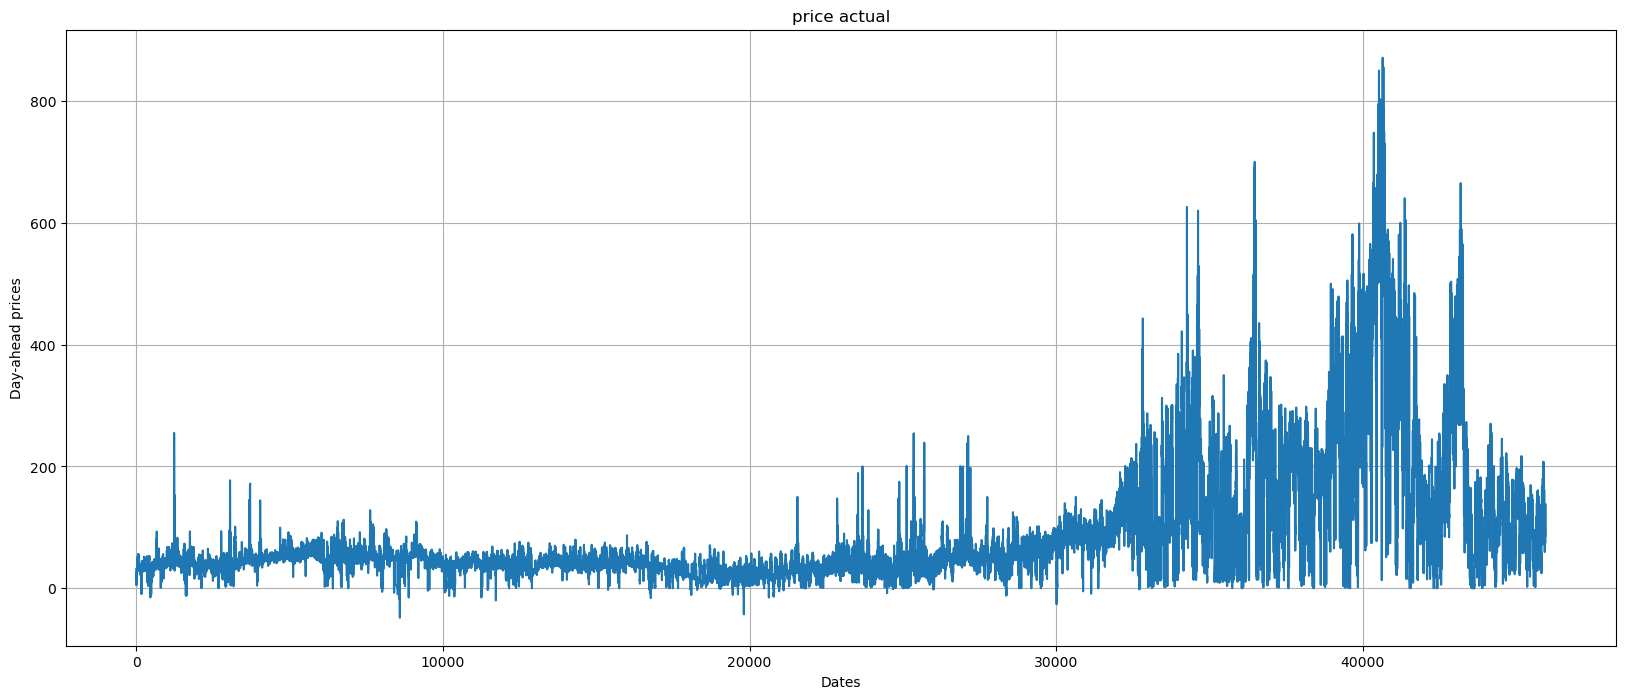

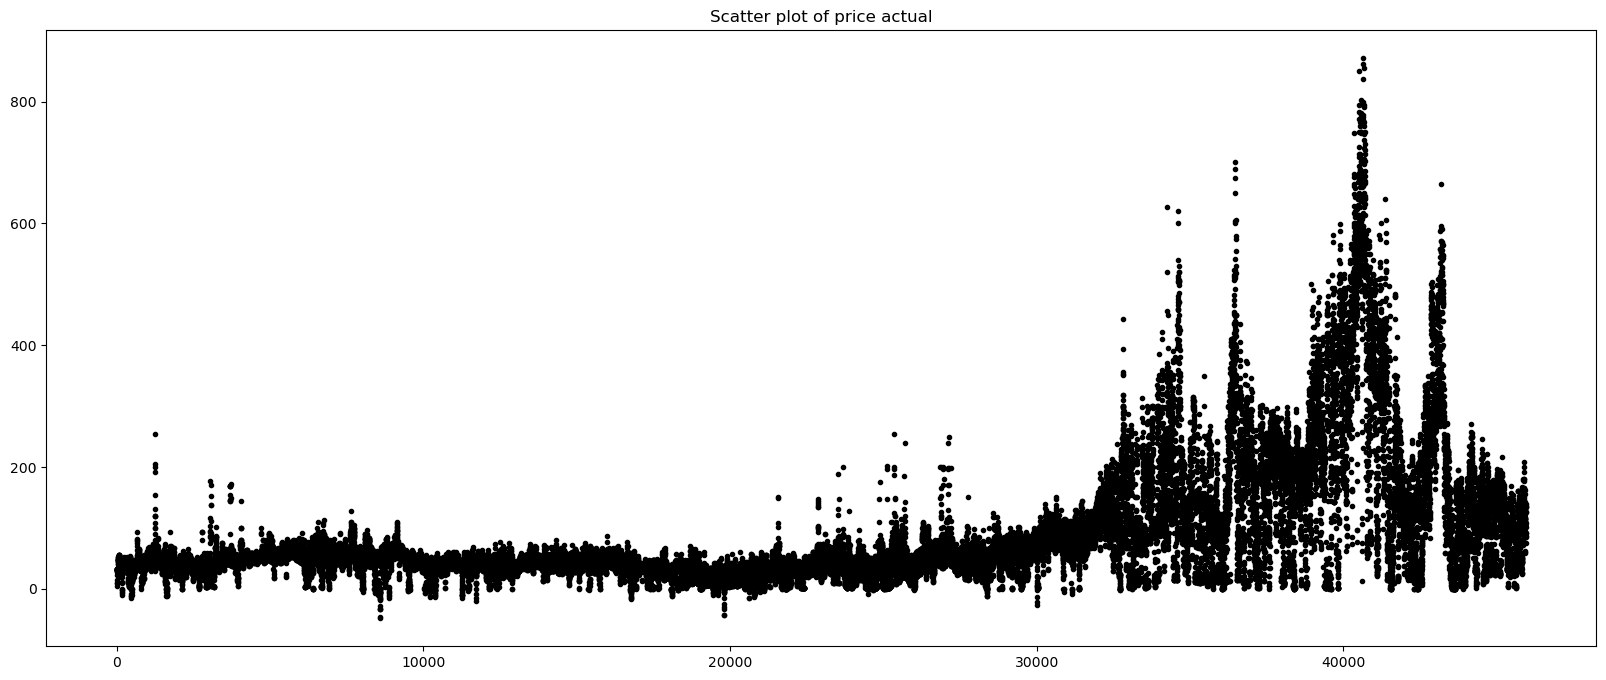

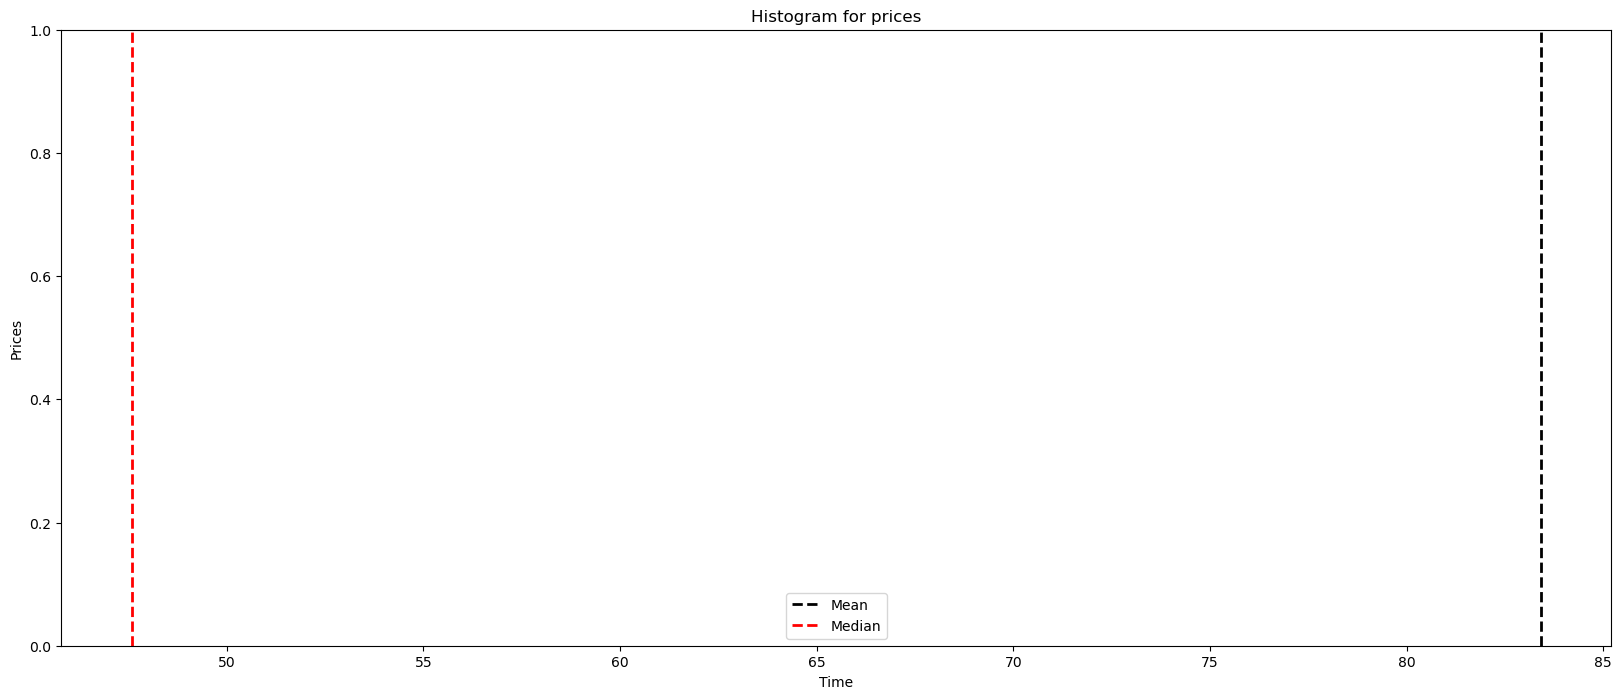

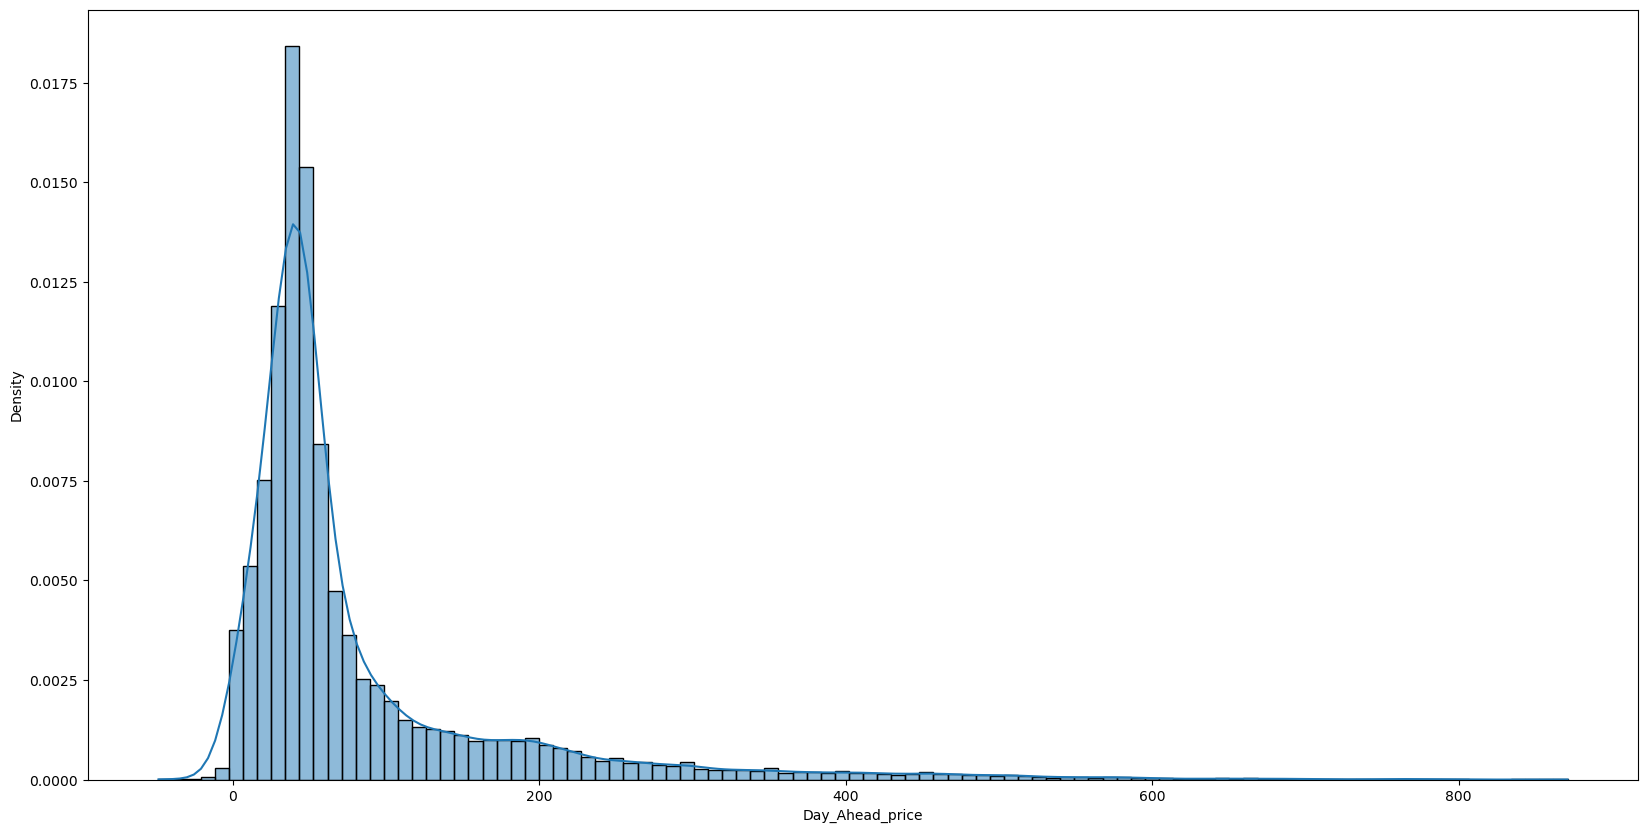

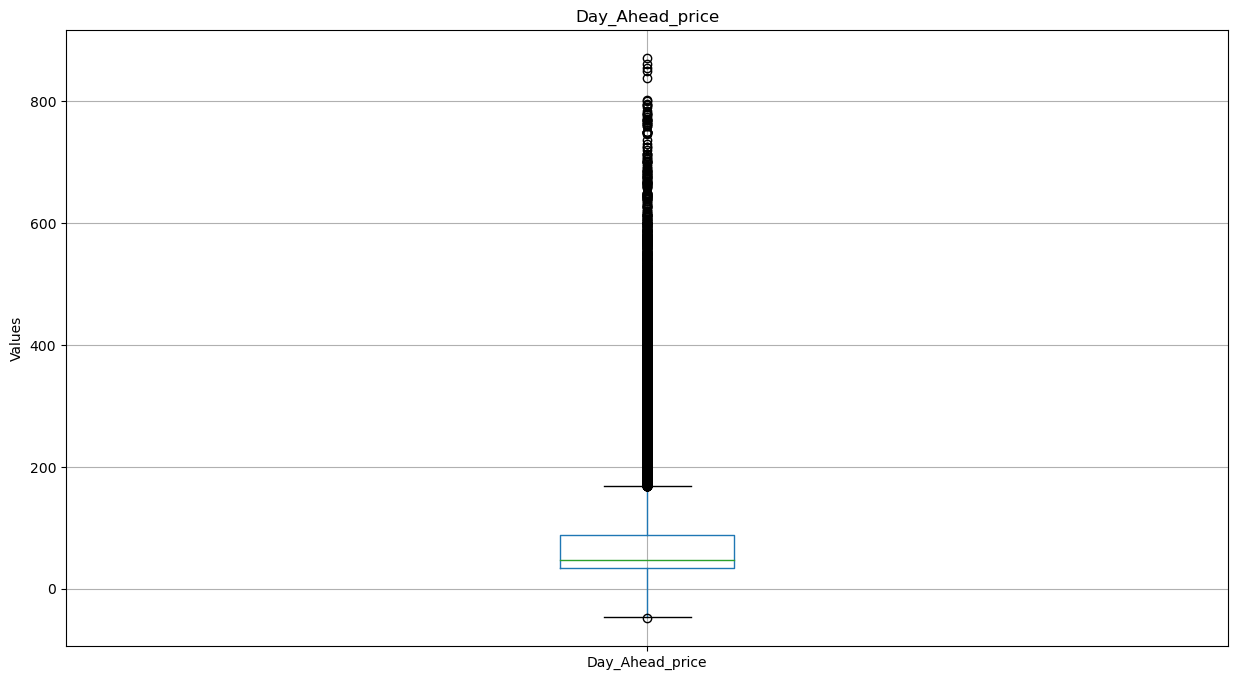

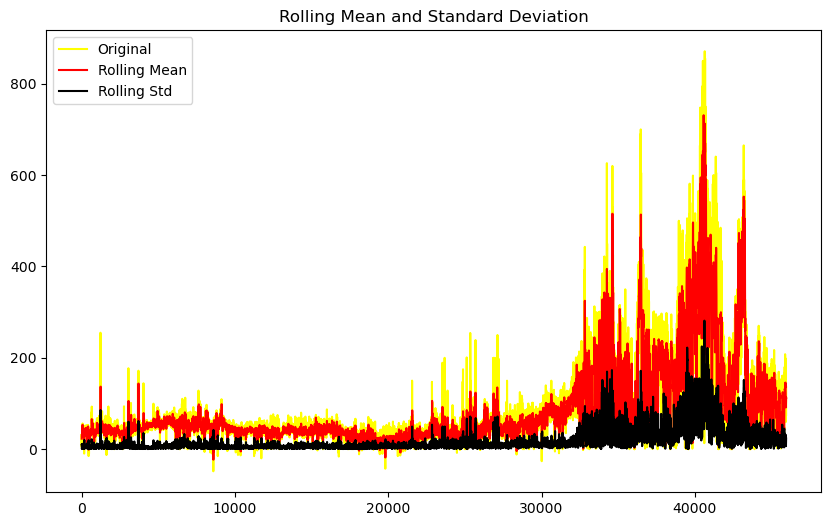

Results of dickey fuller test
Test Statistics               -8.560365e+00
p-value                        8.728720e-14
No. of lags used               5.600000e+01
Number of observations used    4.590000e+04
critical value (1%)           -3.430492e+00
critical value (5%)           -2.861603e+00
critical value (10%)          -2.566804e+00
dtype: float64


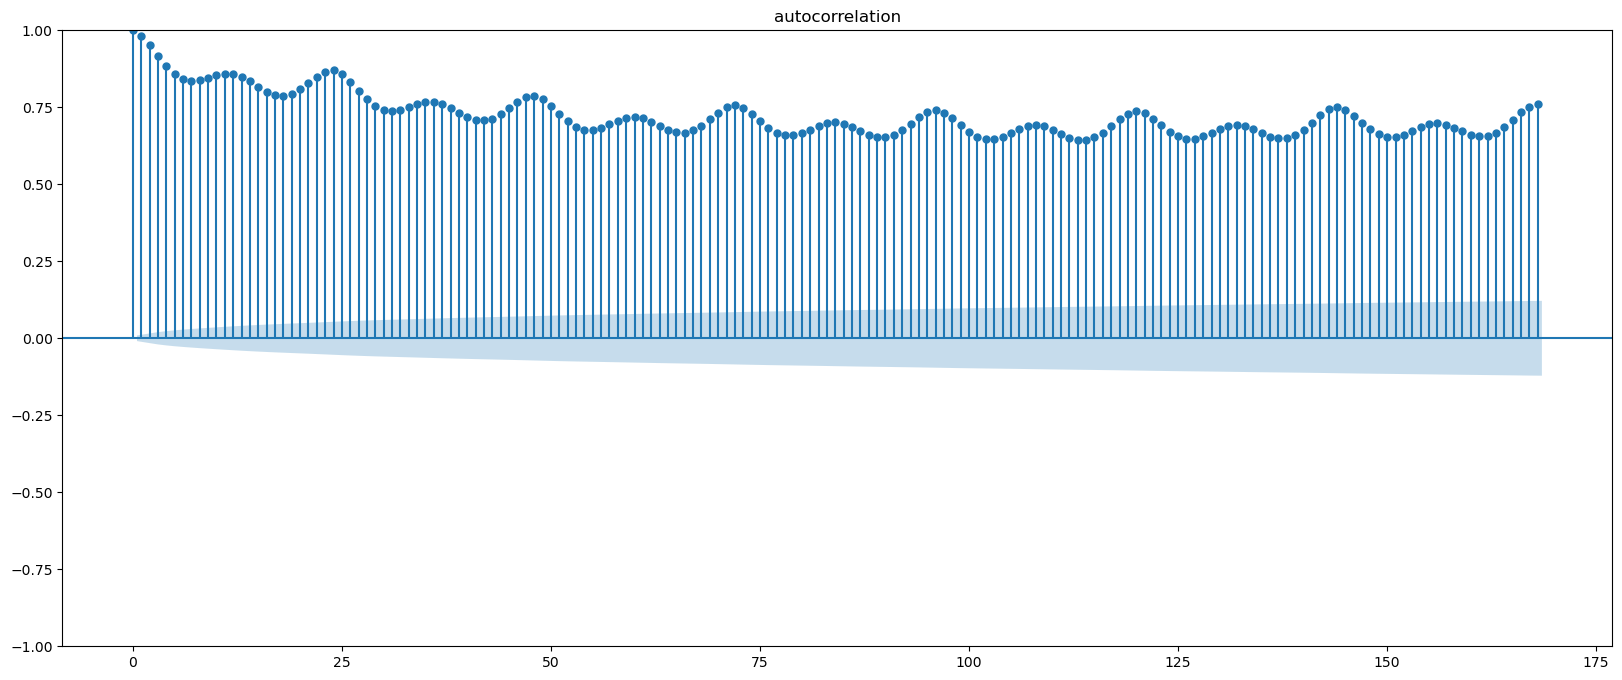

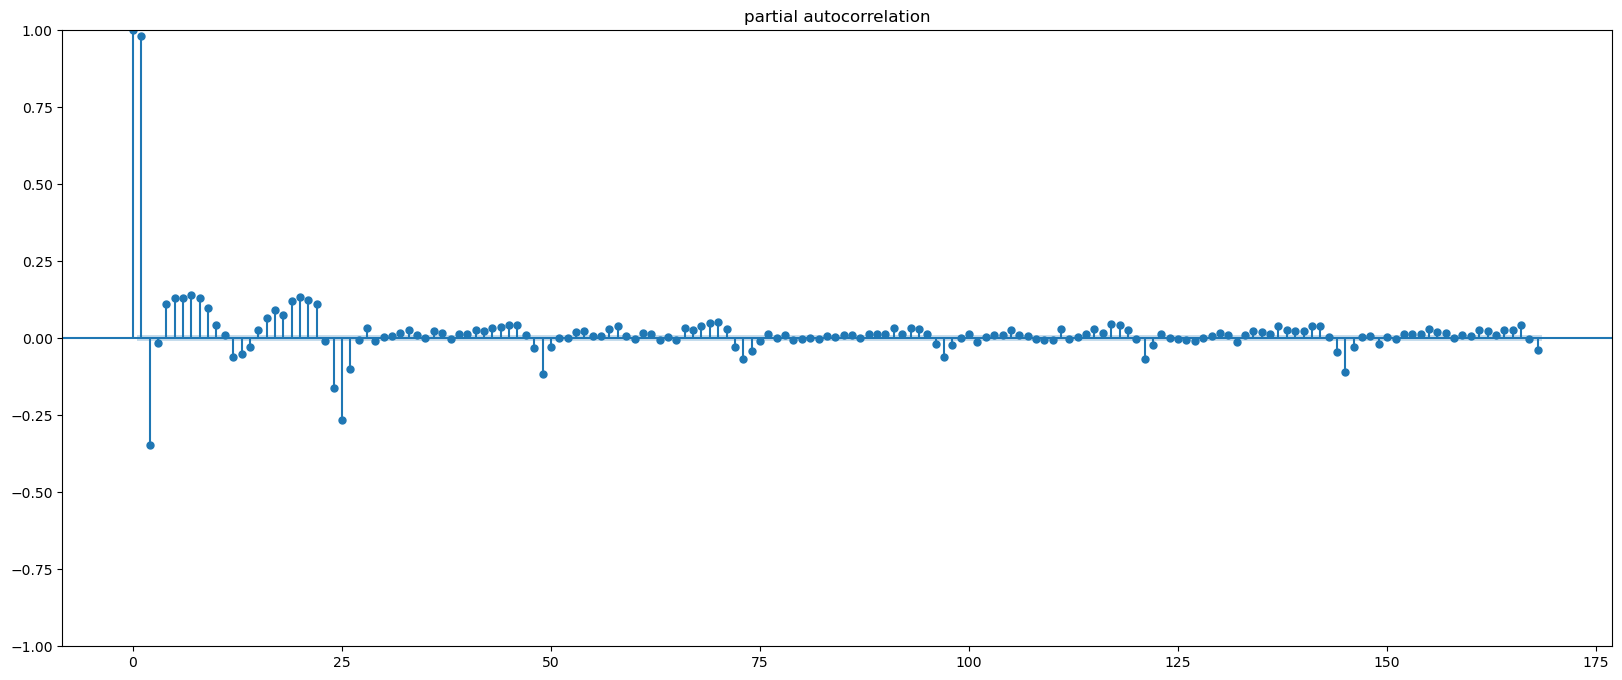

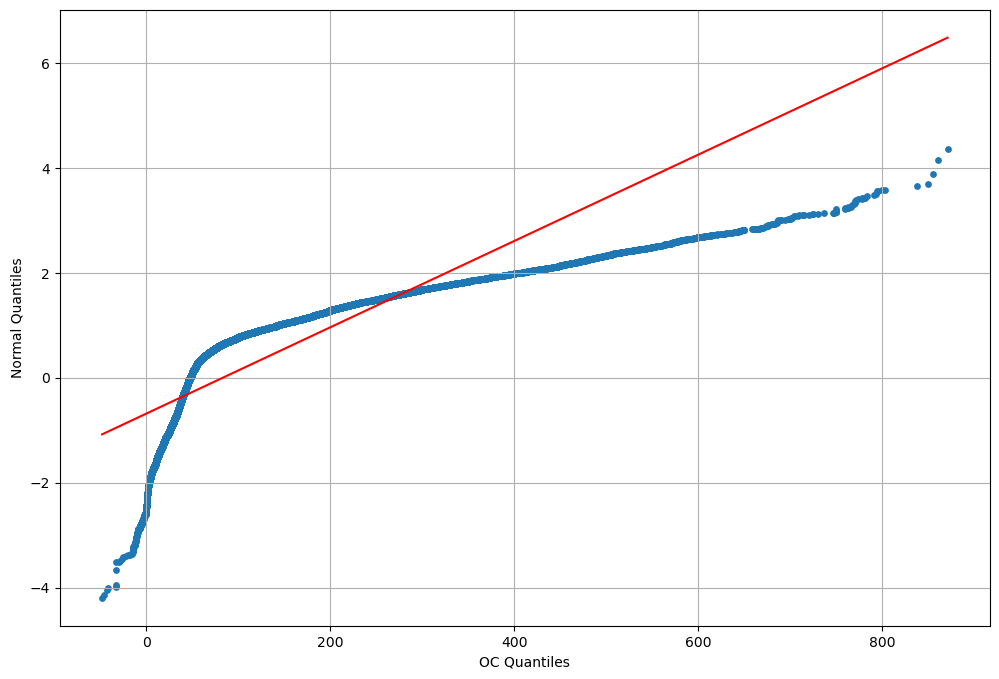

Kurtosis of Day_Ahead_price:  9.654467737387247
Skewness of Day_Ahead_price:  2.828652030966052
Jarque-Bera Result: Jarque_beraResult(statistic=239768.84524722234, pvalue=0.0)
KPSS Statistic: 2.610186
p-value: 0.010000
#Lags used: 119
Critical Value (10%): 0.119000
Critical Value (5%): 0.146000
Critical Value (2.5%): 0.176000
Critical Value (1%): 0.216000


In [6]:
def timing2(df, column,lag):
    plot_n_scat(df[column])
    plot_hist(df[column])
    box(df,column)
    test_stationarity(df[column])
    acf_plot(df[column],lag)
    qqplot(df[column])
    testnormal(df[column])
    kpss_test(df[column])


timing2(df,'Day_Ahead_price',168)

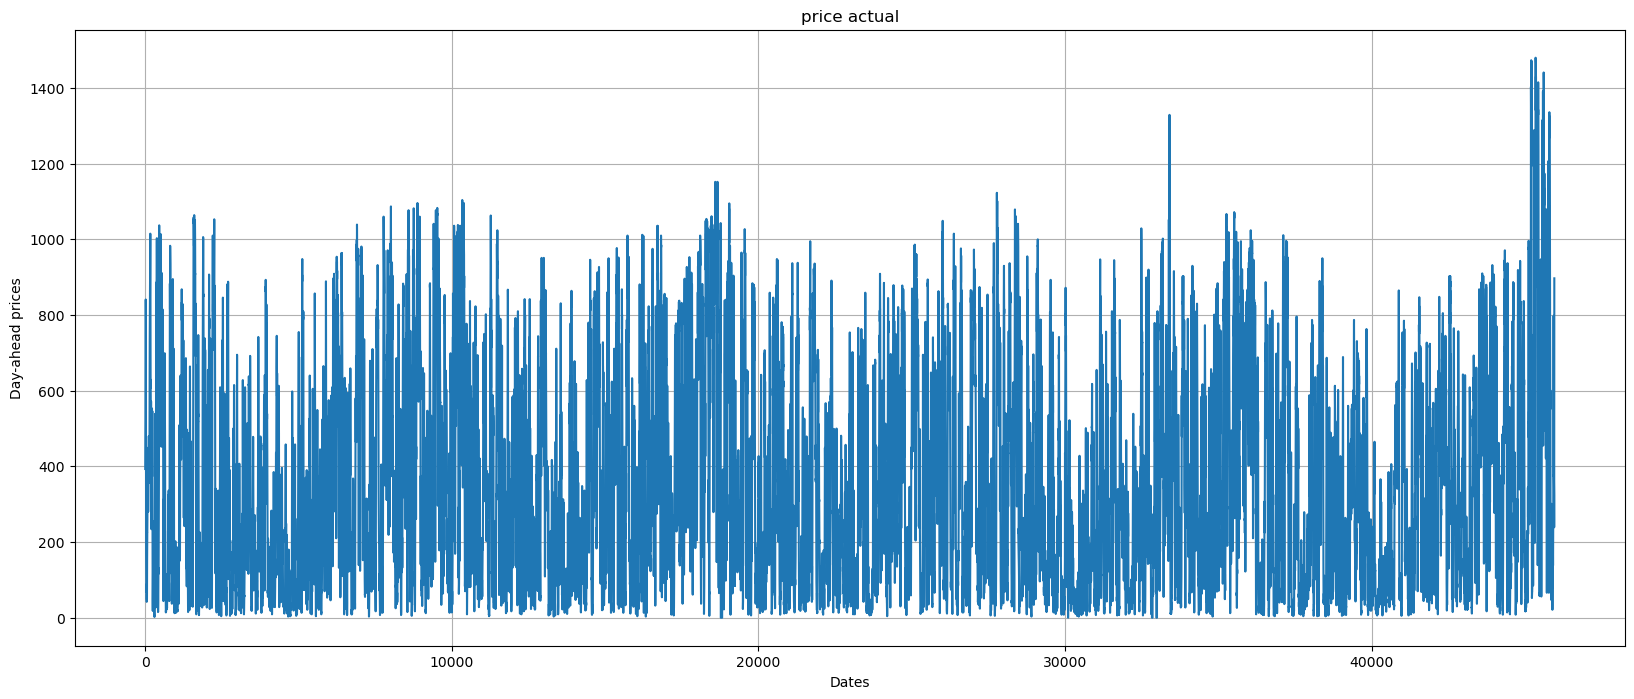

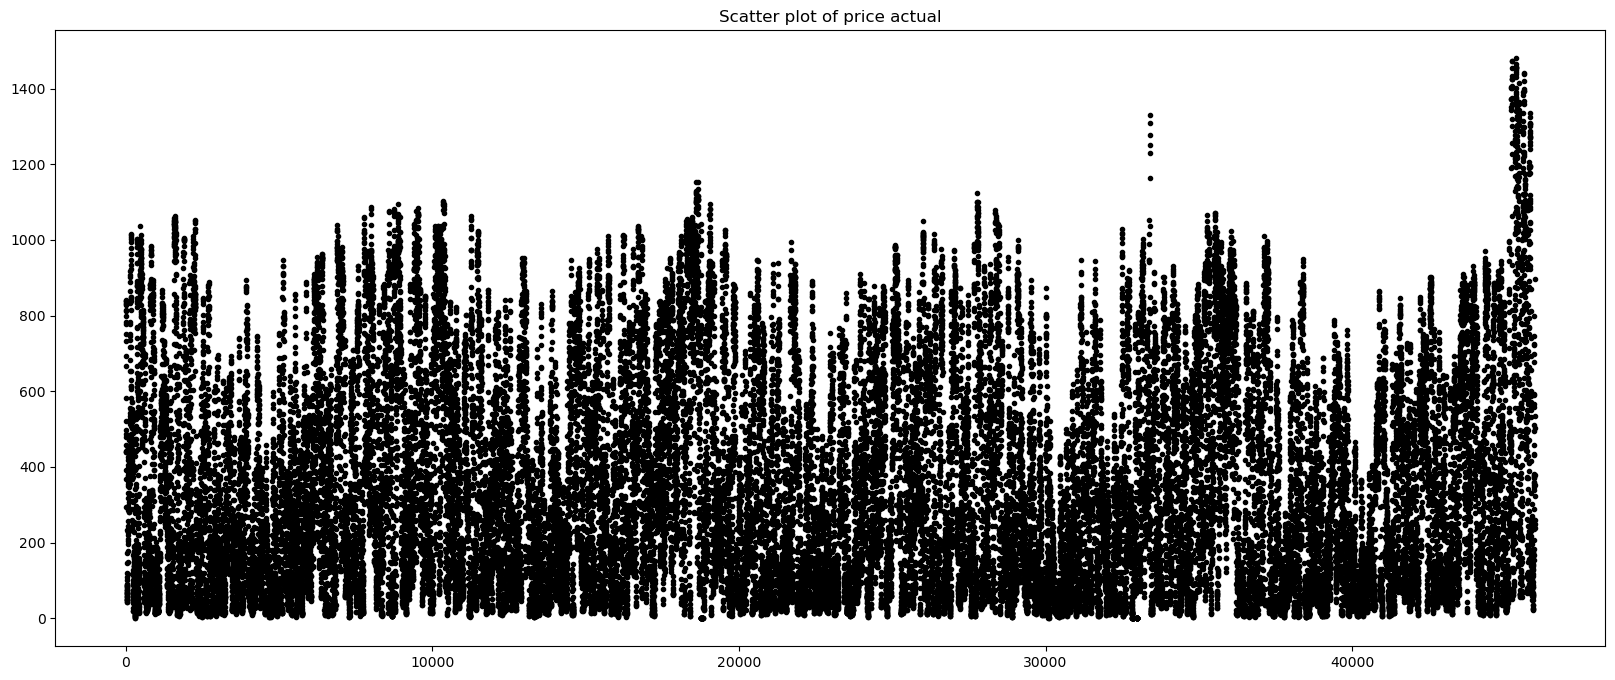

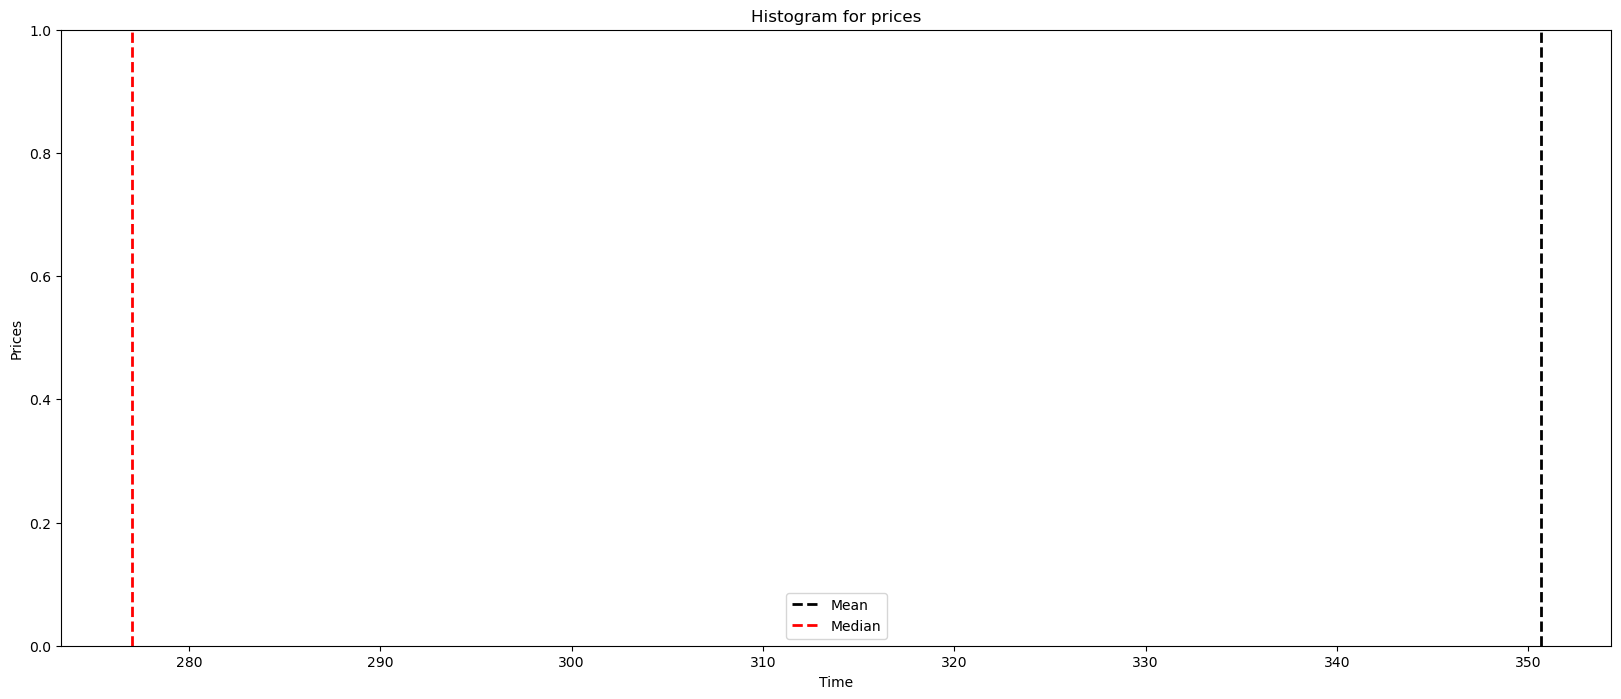

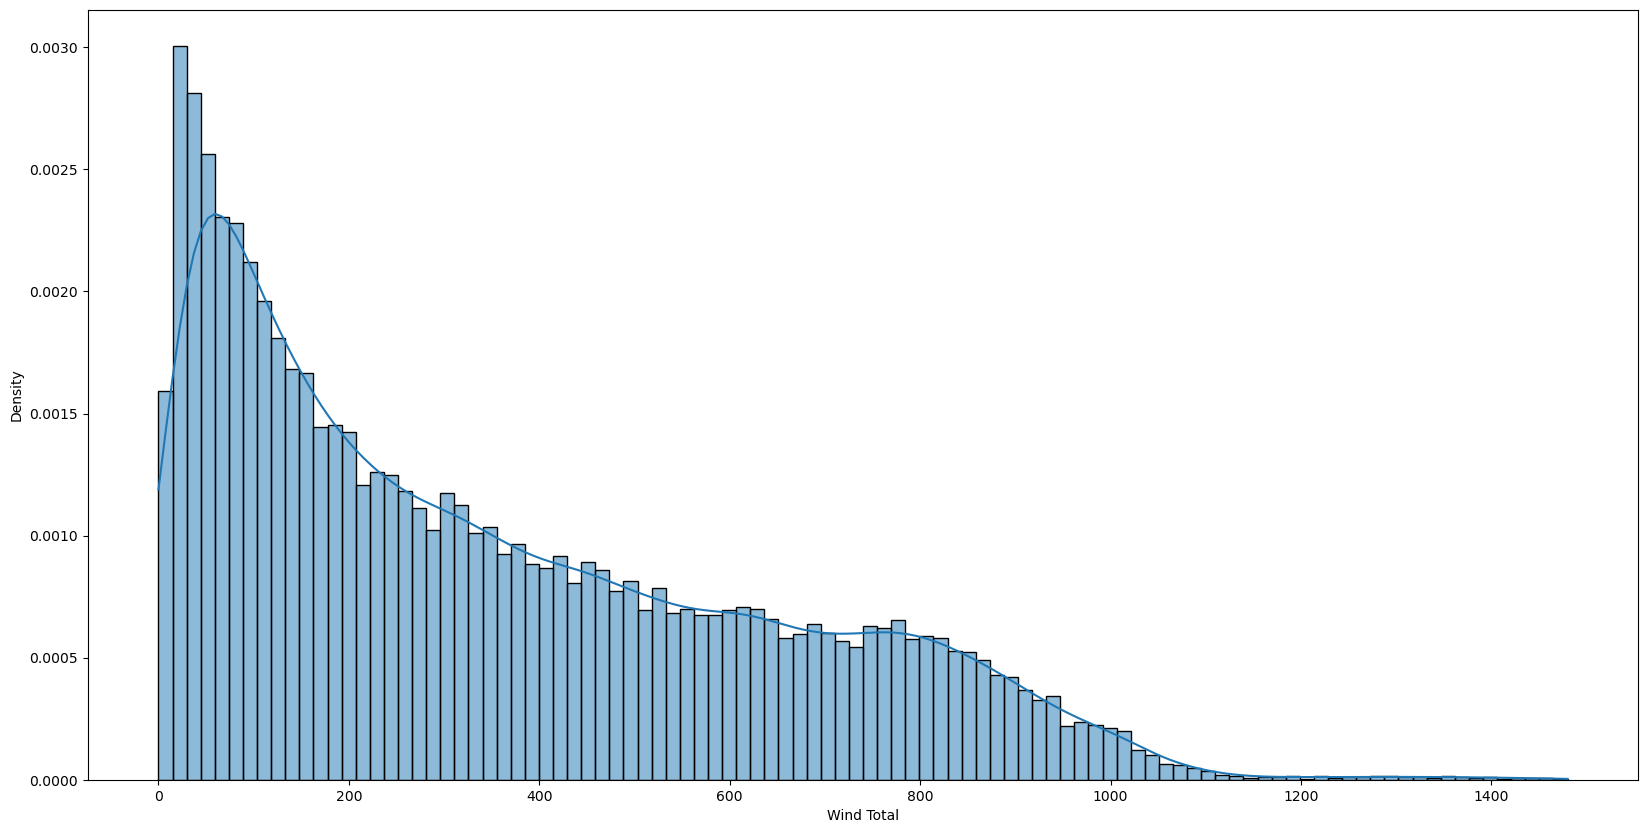

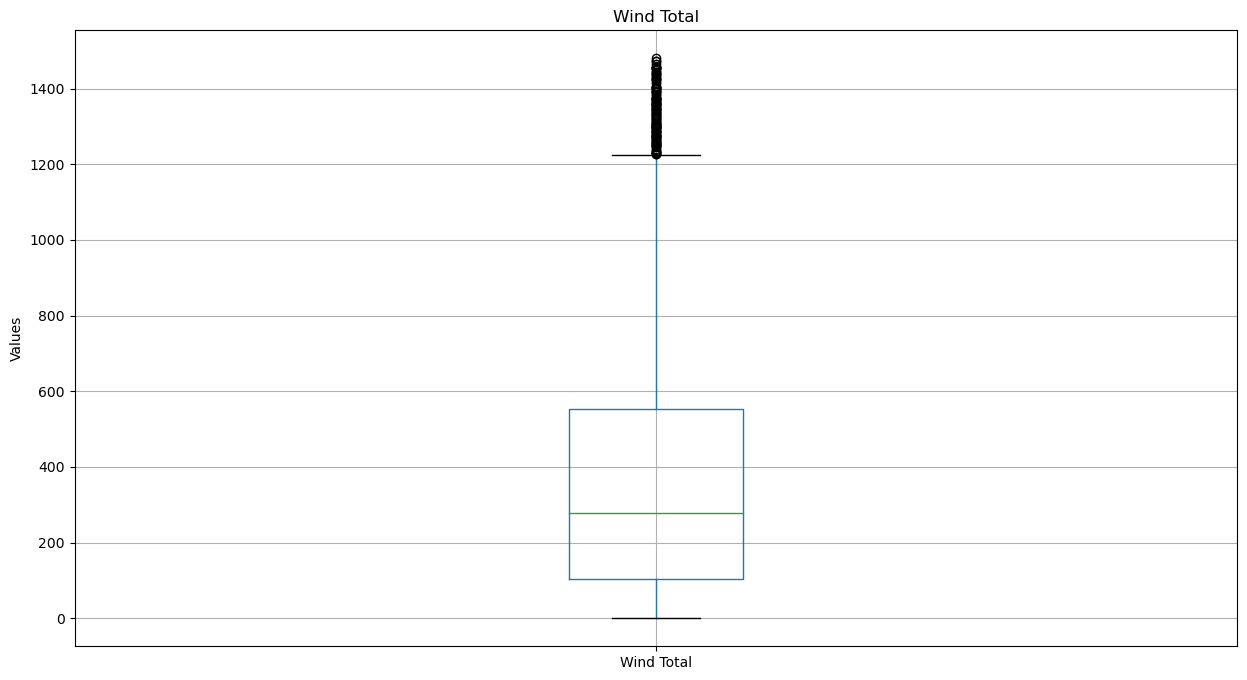

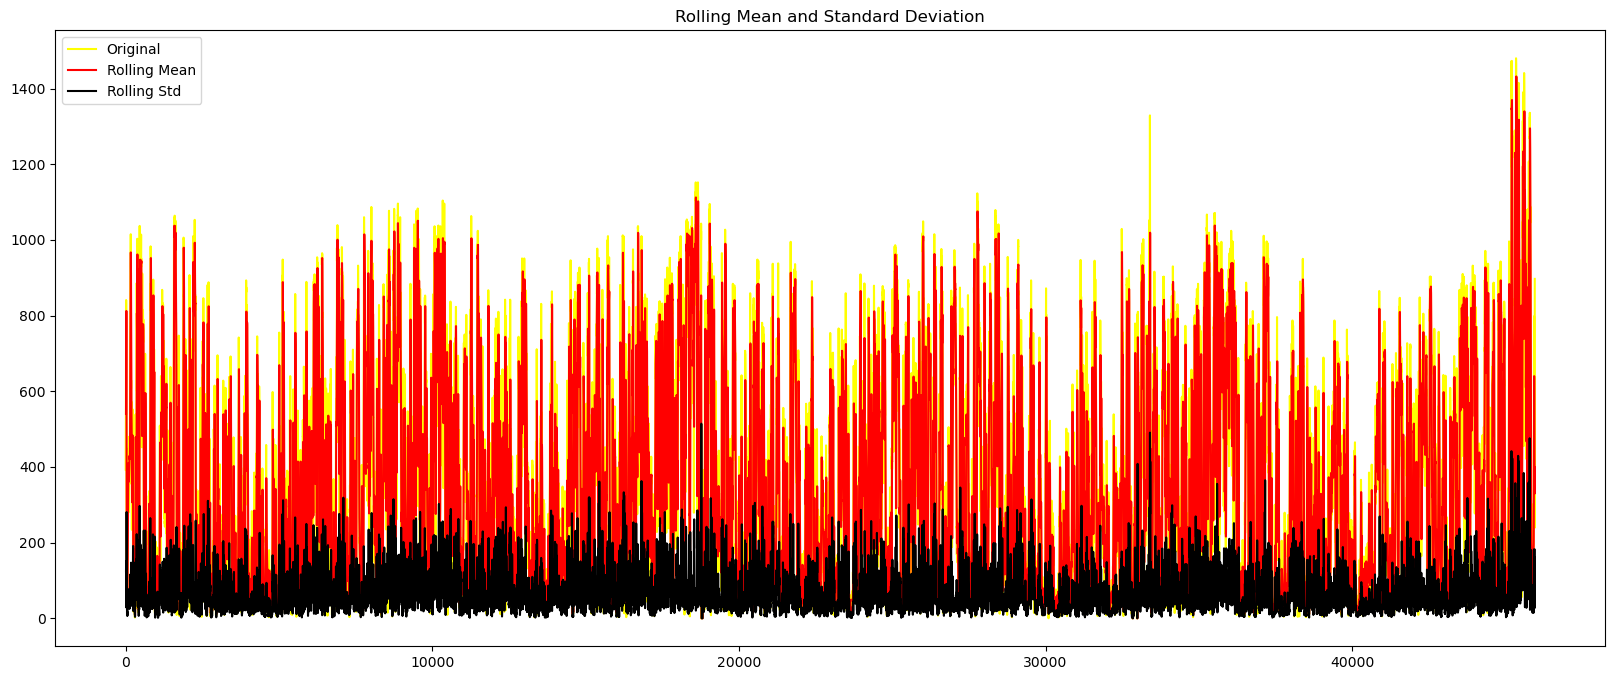

Results of dickey fuller test
Test Statistics                  -18.934956
p-value                            0.000000
No. of lags used                  50.000000
Number of observations used    45906.000000
critical value (1%)               -3.430492
critical value (5%)               -2.861603
critical value (10%)              -2.566804
dtype: float64


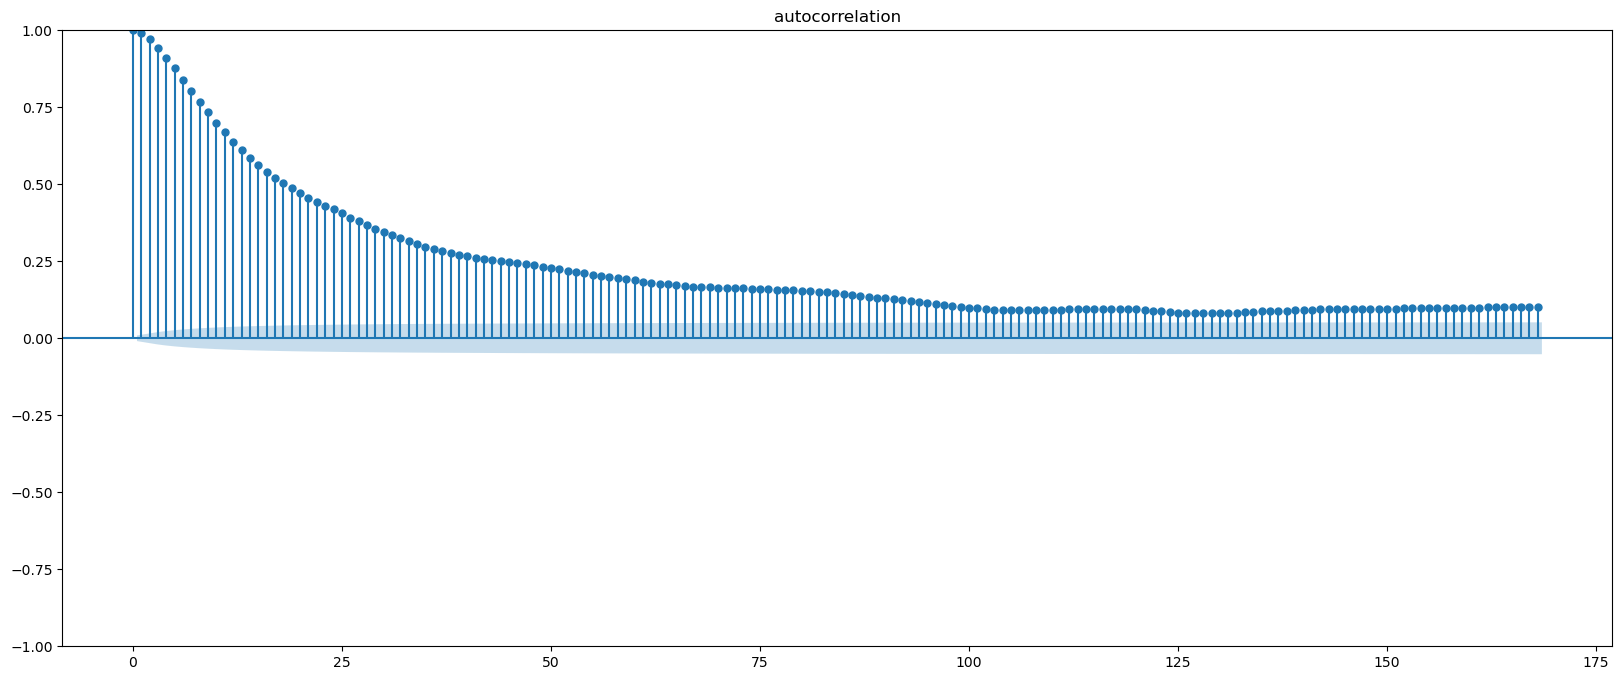

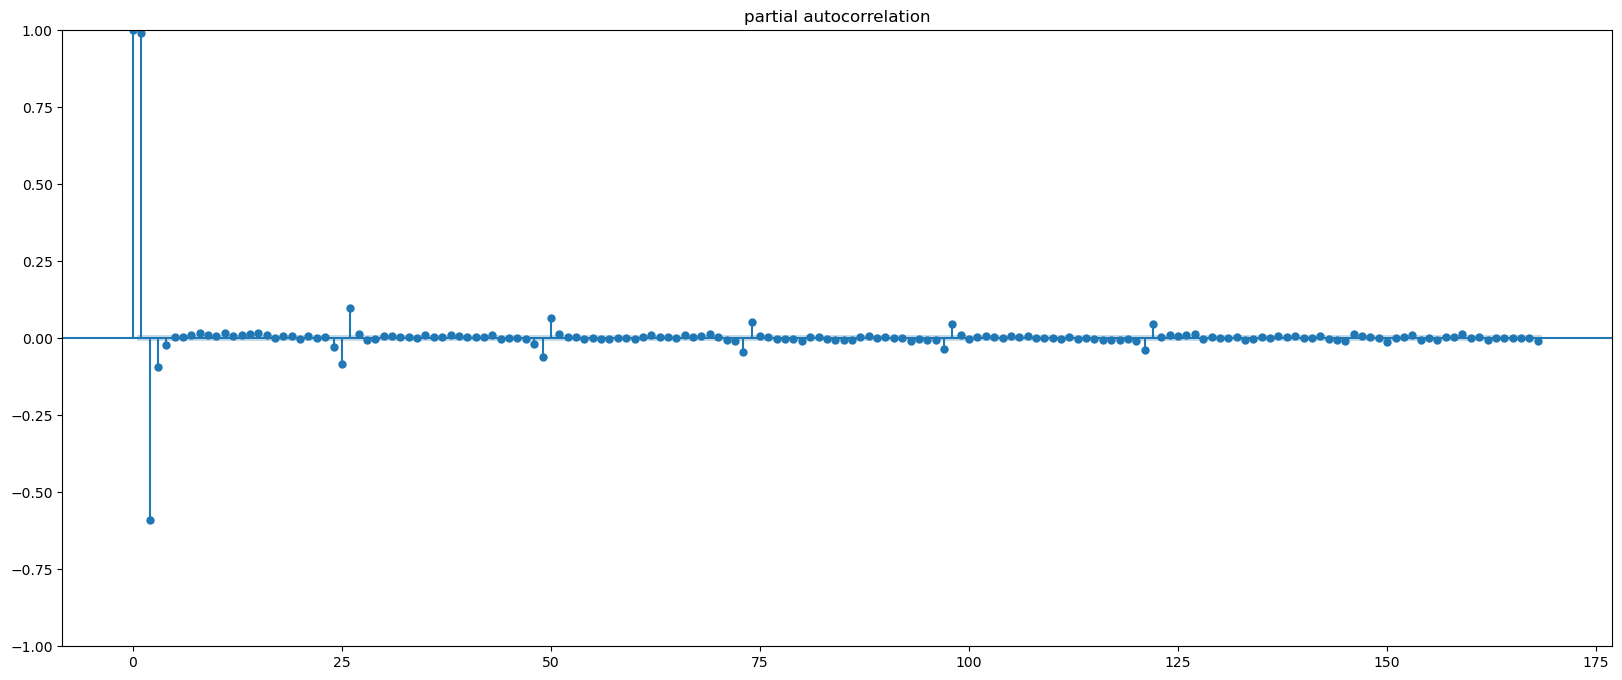

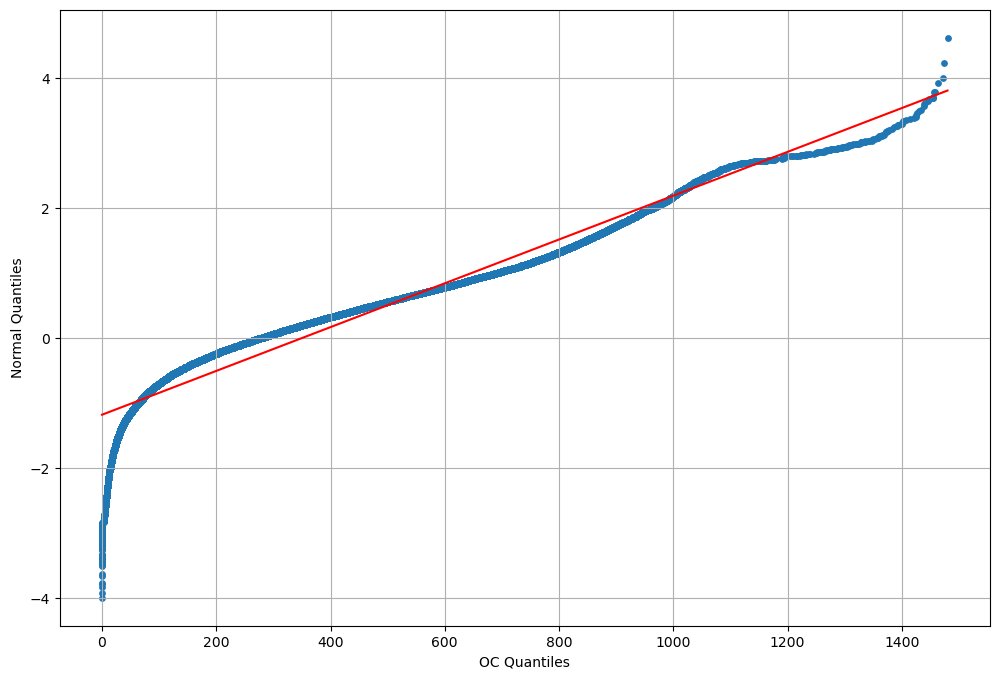

Kurtosis of Wind Total:  -0.4048989412843427
Skewness of Wind Total:  0.7400127055668267
Jarque-Bera Result: Jarque_beraResult(statistic=4508.4168767411265, pvalue=0.0)
KPSS Statistic: 0.208180
p-value: 0.012932
#Lags used: 118
Critical Value (10%): 0.119000
Critical Value (5%): 0.146000
Critical Value (2.5%): 0.176000
Critical Value (1%): 0.216000


In [11]:
timing2(df,'Wind Total',168)#coal_price

# Splitting

## Option 1 - sklearn function

In [5]:
tscv = TimeSeriesSplit(gap = 24*30*0, n_splits = 3, test_size = 24*30*3, max_train_size = df.shape[0])
# gap: observations between train and test set -> 0 months
# n_splits: # of folds
# test_size: observations for test set -> 3 months
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=45957, n_splits=3, test_size=2160)


In [ ]:
for i, (train_index, test_index) in enumerate(tscv.split(df['Timestamp'])):
    print(f"Fold {i}:")
    print(f"  Train: index = {train_index}")
    print(f"  Test:  index = {test_index}")
    
    X_train = df.iloc[train_index].copy()
    X_test = df.iloc[test_index].copy()
    
    plt.plot(X_train['Day_Ahead_price'], label = 'Train F'+str(i+1), linewidth = 0.5)
    plt.plot(X_test['Day_Ahead_price'], label = 'Test F'+str(i+1), linewidth = 0.5)
    plt.xlabel('Time')
    plt.ylabel('Prices\n€/MWh')
    plt.legend()
    plt.show()


Fold 0:
  Train: index = [    0     1     2 ... 39474 39475 39476]
  Test:  index = [39477 39478 39479 ... 41634 41635 41636]


KeyError: 'Day-ahead prices'

## Option 2 - manually

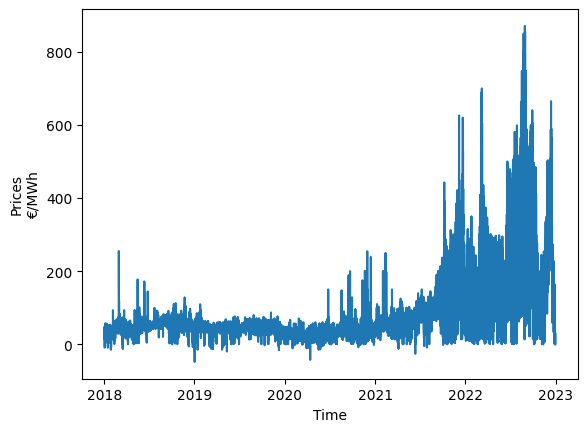

In [7]:
plt.plot(df['Timestamp'], df['Day_Ahead_price'])
plt.xlabel('Time')
plt.ylabel('Prices\n€/MWh')
plt.show()

Fold 1: train 01/01/2018 - 31/12/2020, test 01/01/2021 - 31/03/2021<br>
Fold 2: train 01/01/2018 - 30/06/2021, test 01/07/2021 - 30/09/2021<br>
Fold 3: train 01/01/2017 - 31/08/2022, test 01/09/2022 - 31/12/2022

In [8]:
train_start = ['2018-01-01', '2018-01-01', '2018-01-01']
train_end = ['2020-12-31', '2021-06-20', '2022-08-31']

test_start = ['2021-01-01', '2021-07-01', '2022-09-01']
test_end = ['2021-03-31', '2021-09-30', '2022-12-31']

In [9]:
df2 = df.set_index('Timestamp')

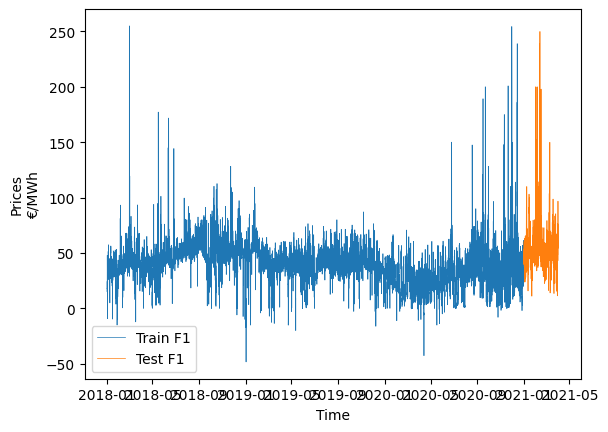

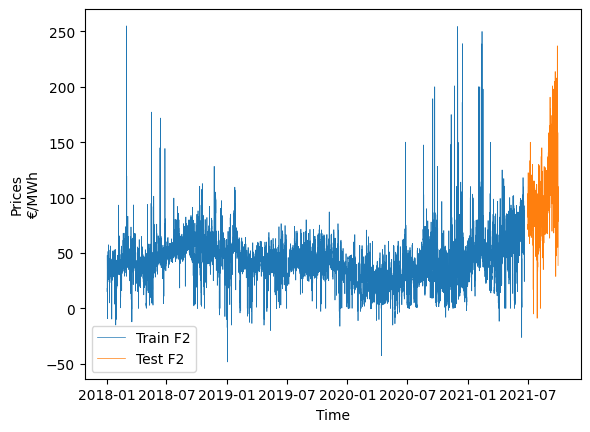

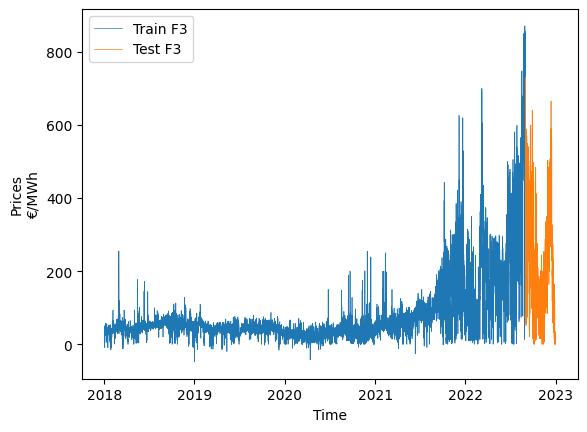

In [10]:
i = 1
for tr_s, tr_e, te_s, te_e in (zip(train_start, train_end, test_start, test_end)):
    
    X_train, X_test = split_timeseries(df2, tr_s, tr_e, te_s, te_e)
    
    plt.plot(X_train['Day_Ahead_price'], label = 'Train F'+str(i), linewidth = 0.5)
    plt.plot(X_test['Day_Ahead_price'], label = 'Test F'+str(i), linewidth = 0.5)
    plt.xlabel('Time')
    plt.ylabel('Prices\n€/MWh')
    plt.legend()
    plt.show()
    
    i += 1